#### Credit Card Fraud Detection:

The purpose of this notebook is to:

- Create a model to determine if a credit card transaction if fraudulent or not. 
- Build familiarity of techniques used to deal with unbalanced datasets. (Random Undersampling / SMOTE)
- Use MlFlow to track experiment runs and performance.
- Use Model Registry from MlFlow. 

Import Packages:

In [297]:
# General:
import time

# Data handling:
import pandas as pd
import numpy as np

# Visualisations:
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
import seaborn as sns
pio.renderers.default = "png"

# Preprocessing:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Models:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Clustering:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# Metrics:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Modelling: 
import mlflow 
from mlflow.tracking import MlflowClient

MlFlow Setup:

In [298]:
# Store mlruns information on sqlite backend.
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#If experiment doesn't already exist, then create it. 
exp_name = "Credit Card Fraud Modelling"
mlflow_exps = [exp._name for exp in mlflow.search_experiments()]
if exp_name not in mlflow_exps:
    mlflow.create_experiment(exp_name)
# Set experiment
mlflow.set_experiment(exp_name)
print("MlFlow Ready! :)")

MlFlow Ready! :)


In [299]:
data = pd.read_csv('./data/creditcard.csv')

Basic EDA to see:

- Number of datapoints. 
- Number of features
- Types of features: categorical/numerical. 

In [300]:
data.shape

(284807, 31)

In [301]:
print(f'Raw features are: {data.columns}')

Raw features are: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Feature type distributions:

In [302]:
data.dtypes.value_counts()

float64    30
int64       1
dtype: int64

In [303]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [304]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Null value check:

In [305]:
null_vals = data.isnull().sum(axis=1).max()
print(f'Number of null values: {null_vals}')

Number of null values: 0


Conclusions:

- We can see that all features aside from the classification column are floats.
- All features aside from "Amount" are labelled as V followed by a number, hence trying to feature reduce intuitavely isn't an option. We can think of these features as outputs of a dimension reduction algorithm like PCA - where we don't know their intuitive meaning.
- No features have missing values.  
- All "V" features have mean 0 suggesting they are already scaled, "Amount" and "Time" have not been scaled. 

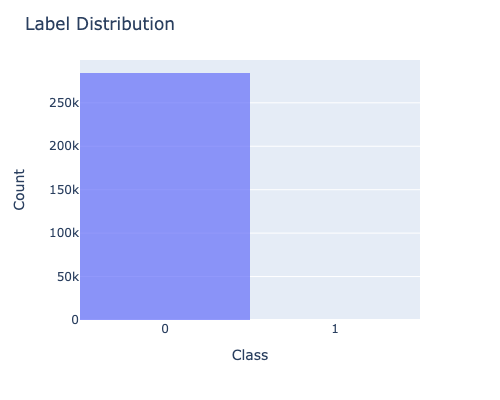

In [306]:
class_fig = px.histogram(data, x="Class", width=500, height=400, opacity=0.7)
class_fig.update_layout(yaxis={"title" : "Count"}, title="Label Distribution", xaxis={"title" : "Class", "tick0" : 0, "dtick" : 1})
class_fig.show()

In [307]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

We can see that only 492/284315 ~ 0.17% of the datapoints are fraudulent. We need to take care on which metrics we use to evaluate model performance as even a basic model suggesting all transactions are non-fraudulent will achieve 99%+ accuracy. 

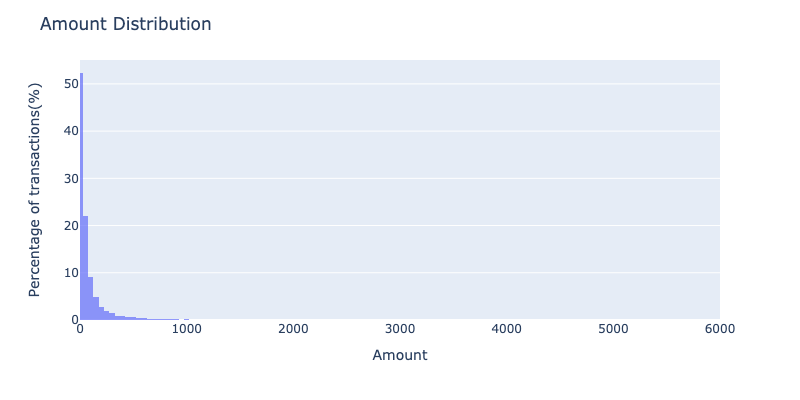

In [308]:
amount_fig = px.histogram(data, x="Amount", histnorm="percent", width=800, height=400, nbins=1000, opacity=0.7)
amount_fig.update_layout(xaxis_range=[0, 6000], title="Amount Distribution", yaxis={"title" : "Percentage of transactions(%)"})
amount_fig.show()

As mentioned previously, we have an unbalanced dataset. To build our training dataset I'll take the complete list of fraudulent transactions and randomly sample an equal number of non-fraudulent transactions. That way although our training dataset will be much smaller, it will be balanced. - this technique is called "Random Undersampling"

In [309]:
# Will use all fraudulent transactions in new dataset:
fraud_df = data.loc[data["Class"] == 1]
non_fraud_df = data.loc[data["Class"] == 0]

num_fraud = fraud_df.shape[0]
non_fraud_df_sample = non_fraud_df.sample(n=num_fraud)

model_df = pd.concat([fraud_df, non_fraud_df_sample])
#Shuffling dataset as some models behave differently based on order:
model_df = model_df.sample(frac=1, random_state=42)

In [310]:
model_df.shape

(984, 31)

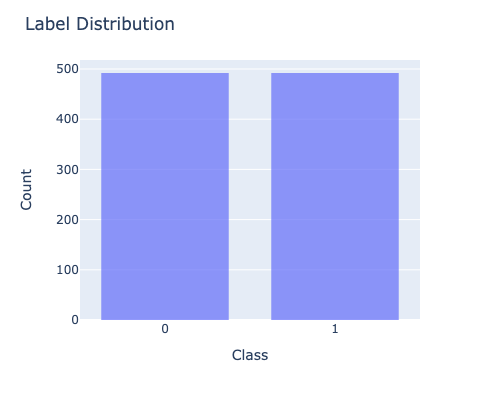

In [311]:
class_fig_balanced = px.histogram(model_df, x="Class", width=500, height=400, opacity=0.7)
class_fig_balanced.update_layout(yaxis={"title" : "Count"}, title="Label Distribution", xaxis={"title" : "Class", "tick0" : 0, "dtick" : 1}, bargap=0.25)
class_fig_balanced.show()

##### Correlation Matrices:




Here I plot a correlation matrix to understand which features may have the most predictive power in determining whether a transaction is fraudulent or not. 

Notes:

- Plot the correlation matrix with the balanced dataset as this will help us understand which features have predictive power on both fraud/non-fraudulent transactions. Using the unbalanced dataset will likely just show which features are correlated with non-fraudulent transactions. 
- Features that are highly correlated - atleast one can be dropped. 
- We can try to remove outliers from features that are highly correlated with the label. Extreme values can "stretch" decision boundaries, however need to be careful in determining what an outlier is to avoid information loss. We should test both cases and see if outlier removal has been useful or not. 

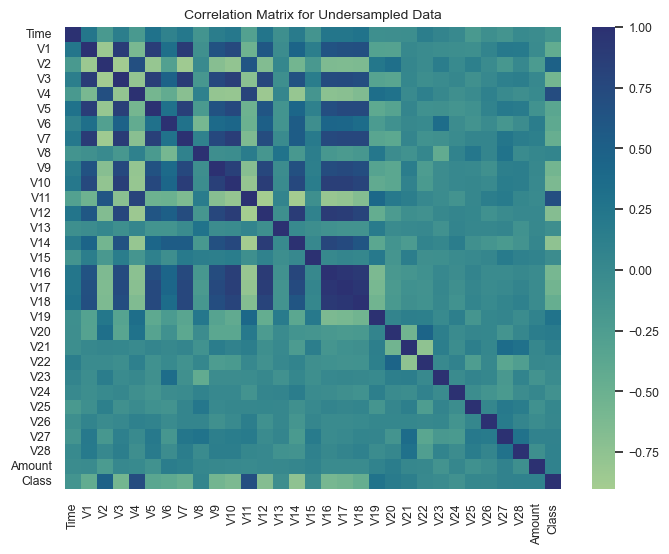

In [312]:
# All features are numerical hence all features are in the corr_mat.
corr_mat = model_df.corr()
sns.set(font_scale=0.8)
plt.figure(figsize=(8, 6), dpi=100)
corr_mat_plot = sns.heatmap(corr_mat, cmap="crest", xticklabels=True, yticklabels=True)
plt.title("Correlation Matrix for Undersampled Data", fontsize=10)
plt.show()

In [313]:
corr_mat.loc[corr_mat["Class"] >=0.65]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V4,-0.202146,-0.610940,0.687477,-0.776735,1.000000,-0.577263,-0.432464,-0.713586,0.105537,-0.787030,...,-0.013941,0.112227,0.018564,-0.082951,-0.020042,0.105819,-0.016300,-0.068890,-0.004904,0.715473
V11,-0.301998,-0.528714,0.617973,-0.717595,0.804745,-0.520521,-0.506207,-0.637164,0.165467,-0.700510,...,0.143466,0.008888,-0.036129,-0.128392,0.024876,0.143315,0.181551,0.028320,-0.015027,0.691200
Class,-0.132578,-0.437890,0.490182,-0.570604,0.715473,-0.364781,-0.400372,-0.474628,0.054369,-0.562715,...,0.129613,-0.000767,-0.030041,-0.101911,0.032322,0.022397,0.080715,0.087778,0.087695,1.000000


In [314]:
corr_mat.loc[corr_mat["Class"] <= -0.65]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V12,0.255950,0.595764,-0.668989,0.763429,-0.840520,0.615173,0.513082,0.718030,-0.16090,0.765668,...,-0.076240,-0.101973,0.018865,0.045605,0.032967,-0.096414,-0.030495,0.004637,0.011438,-0.686106
V14,0.170778,0.444074,-0.566920,0.655445,-0.798701,0.423943,0.540506,0.540733,-0.18206,0.676713,...,-0.228814,0.071126,0.030593,0.146328,-0.086076,-0.154820,-0.208943,-0.126512,0.034138,-0.748450


Let's draw some boxplots of these correlated features to understand their distributions and number of outliers that might affect our model. We split the distributions by class as what might be an outlier for one class may not be an outlier for another class. Our dataset has only a 1000 datapoints so need to be careful to track number of datapoints removed. 

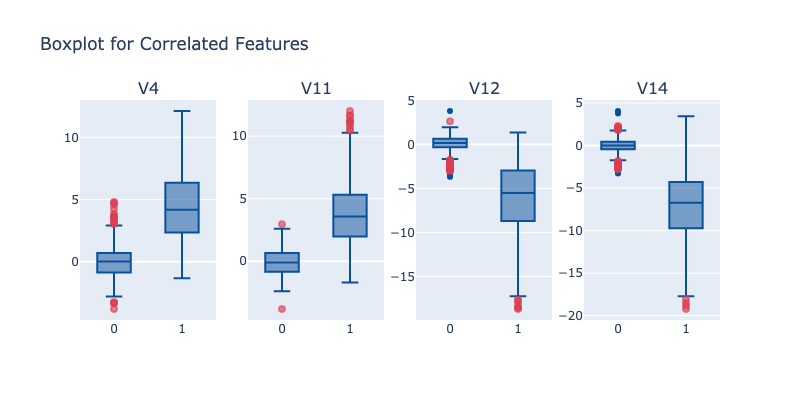

In [315]:
pos_corr = ["V4", "V11"]
neg_corr = ["V12", "V14"]

corr_ftrs = pos_corr + neg_corr

box_plots = make_subplots(rows=1, cols=4,
                          subplot_titles=corr_ftrs)

for row_num, ftr in enumerate(corr_ftrs):

    for class_label in [0,1]:
        sub_df = model_df.loc[model_df["Class"] == class_label]
    # fraud_sub_df = model_df.loc[model_df["Class"] == 1]
    # non_fraud_sub_df = model_df.loc[model_df["Class"] == 0]

        box_plots.add_trace(go.Box(y=sub_df[ftr],
                                   x=sub_df["Class"],
        name=f"Suspected Outliers - {ftr}",
        boxpoints='suspectedoutliers', # only suspected outliers
        marker=dict(
            color='rgb(8,81,156)',
            outliercolor='rgba(219, 64, 82, 0.6)',
            line=dict(
                outliercolor='rgba(219, 64, 82, 0.6)',
                outlierwidth=2)),
        line_color='rgb(8,81,156)'), 
        row=1, col=row_num+1)

box_plots.update_layout(title="Boxplot for Correlated Features", showlegend=False, height=400, width=800)
box_plots.show()


Given that the original dataset is unbalanced largely towards the 0 class, we can assume that datapoints that have been randomly undersampled are within suitable range ie: are representative of the datapoints recieved at inferance time. So below I remove the outliers for features V11, V12, V14 only for the positive class. Lets first track the number of datapoints in the worst case that will be removed:

In [316]:
# May need to vary outlier threshold as can't afford to discard too many datapoints. 
outlier_thresh = 1.5
ftrs = ["V11", "V12", "V14"]
quartiles_array = np.array([25, 75])
pos_df = model_df.loc[model_df["Class"] == 1]
total_datapoints_to_remove = 0

for ftr in ftrs:
    quartiles = np.percentile(pos_df[ftr].values, quartiles_array)
    iqr = quartiles[1] - quartiles[0]
    upper_bound = quartiles[1] + outlier_thresh * iqr
    lower_bound = quartiles[0] - outlier_thresh * iqr
    no_outlier_df = pos_df.loc[(pos_df[ftr] > upper_bound) | (pos_df[ftr] < lower_bound)]
    num_removed = no_outlier_df.shape[0]
    total_datapoints_to_remove += num_removed
    
    print(f'For Features: {ftr}')
    print('---' * 15)
    print(f'Q3: {quartiles[1]:.3f}')
    print(f'Q1: {quartiles[0]:.3f}')
    print(f'IQR: {iqr:.3f}')
    print(f'Upper Outlier Bound: {upper_bound:.3f}')
    print(f'Lower Outlier Bound: {lower_bound:.3f}')
    print(f'Number of Datapoints being removed: {num_removed}')
    print('---' * 15)

print(f'Total number of datapoints potentially removed: {total_datapoints_to_remove}')

For Features: V11
---------------------------------------------
Q3: 5.307
Q1: 1.973
IQR: 3.334
Upper Outlier Bound: 10.308
Lower Outlier Bound: -3.027
Number of Datapoints being removed: 10
---------------------------------------------
For Features: V12
---------------------------------------------
Q3: -2.974
Q1: -8.688
IQR: 5.714
Upper Outlier Bound: 5.597
Lower Outlier Bound: -17.259
Number of Datapoints being removed: 6
---------------------------------------------
For Features: V14
---------------------------------------------
Q3: -4.283
Q1: -9.693
IQR: 5.410
Upper Outlier Bound: 3.832
Lower Outlier Bound: -17.808
Number of Datapoints being removed: 4
---------------------------------------------
Total number of datapoints potentially removed: 20


Removing at most 20 datapoints out of 492 is around 4% , which is accpetable for now. Proceed to remove these "outliers":

In [317]:
# May need to vary outlier threshold as can't afford to discard too many datapoints. 
outlier_thresh = 1.5
ftrs = ["V11", "V12", "V14"]
quartiles_array = np.array([25, 75])
pos_df = model_df.loc[model_df["Class"] == 1]
neg_df = model_df.loc[model_df["Class"] == 0]

for ftr in ftrs:
    quartiles = np.percentile(pos_df[ftr].values, quartiles_array)
    iqr = quartiles[1] - quartiles[0]
    upper_bound = quartiles[1] + outlier_thresh * iqr
    lower_bound = quartiles[0] - outlier_thresh * iqr
    pos_df = pos_df.loc[(pos_df[ftr] <= upper_bound) & (pos_df[ftr] >= lower_bound)]

no_outlier_df = pd.concat([pos_df, neg_df], axis=0)
no_outlier_df.sample(frac=1, random_state=42)
no_outlier_df.reset_index(drop=True, inplace=True)

print(f'---' * 30)
print(f'Number of datapoints remaining after outlier removal: {no_outlier_df.shape[0]}')

------------------------------------------------------------------------------------------
Number of datapoints remaining after outlier removal: 969


#### Dimension Reducation and Clustering:

We know we can use dimension reduction along with clustering techniques to get an idea of how might our predictive models perform. Predictive models are built by creating decision boundaries around clusters - this boundary is learnt during the training process. Reducing the dimensions allows us to visualise our datapoints to get an idea as to whether such a boundary may exist. The visualisation will naturally vary based on the dimension reduction technique, below I use 3 methods to reduce our data matrix to 2 coordnates: 

- PCA
- T-SNE
- Truncated SVD

In [318]:
no_outlier_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,153875.0,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,...,0.319261,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,0.00,1
1,150139.0,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,...,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,237.26,1
2,85285.0,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,-4.684952,...,0.954272,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,252.92,1
3,93853.0,-5.839192,7.151532,-12.816760,7.031115,-9.651272,-2.938427,-11.543207,4.843627,-3.494276,...,2.462056,1.054865,0.530481,0.472670,-0.275998,0.282435,0.104886,0.254417,316.06,1
4,109298.0,-1.000611,3.346850,-5.534491,6.835802,-0.299803,0.095951,-2.440419,1.286301,-2.766438,...,0.439757,-0.694099,0.299660,-0.657601,0.101648,0.430457,0.824685,0.326952,186.13,1


In [319]:
# Drop class as not needed in reduction.
only_normalised_df = no_outlier_df.drop(columns=["Time", "Amount"])
X = only_normalised_df.drop('Class', axis=1)
y = only_normalised_df['Class']

# T-SNE Implementation
t_0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t_1 = time.time()
t_diff = t_1-t_0
print(f"T-SNE Fitted - {t_diff:.2f}s")

# PCA Implementation
t_0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t_1 = time.time()
t_diff = t_1-t_0
print(f"PCA Fitted - {t_diff:.2f}s")

# TruncatedSVD
t_0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t_1 = time.time()
t_diff = t_1-t_0
print(f"Truncated SVD Fitted - {t_diff:.2f} s")

T-SNE Fitted - 6.49s
PCA Fitted - 0.00s
Truncated SVD Fitted - 0.01 s


We can see PCA and Truncted SVD were fit extremely quick. In this case it doesn't make much difference as I will only use the reduced matrices for visualisations and NOT training. If we were using for training then same reduction method would need to be used at inferance level and hence should be time to reduce should be factored in. 

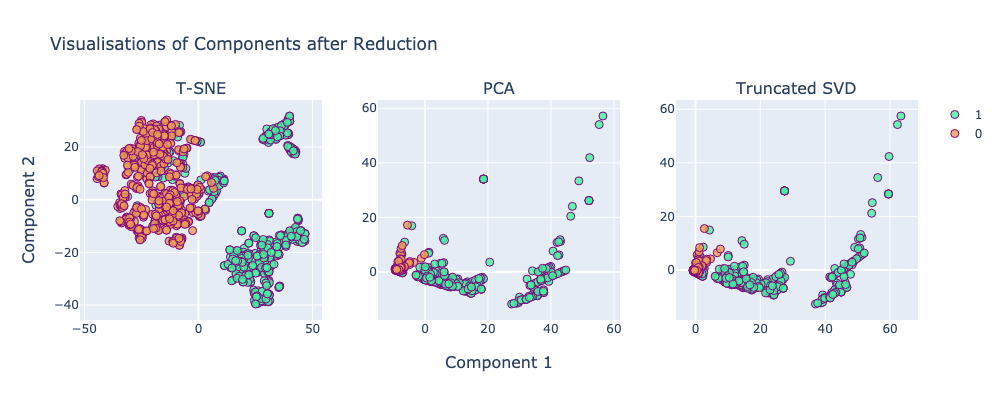

In [320]:
reduced_plot = make_subplots(rows=1, 
                             cols=3,
                             subplot_titles=["T-SNE", "PCA", "Truncated SVD"], 
                             x_title="Component 1",
                             y_title="Component 2")

reduced_dfs = [X_reduced_tsne, X_reduced_pca, X_reduced_svd]

# Remove duplicated legend:
show_legend = True
counter = 0

for fig_no, reduced_df in enumerate(reduced_dfs):
    with_label_df = pd.DataFrame(reduced_df, columns=["Component 1", "Component 2"])
    with_label_df["Class"] = y

    pos_df = with_label_df.loc[with_label_df["Class"] == 1]
    neg_df = with_label_df.loc[with_label_df["Class"] == 0]
    
    if counter > 0:
        show_legend = False
    
    reduced_plot.add_trace(go.Scatter(x=pos_df["Component 1"], y=pos_df["Component 2"], mode="markers", 
                                      marker_color='rgba(66, 245, 158, .8)', showlegend=show_legend, name="1"),
                                      row=1, col=fig_no+1)
    reduced_plot.add_trace(go.Scatter(x=neg_df["Component 1"], y=neg_df["Component 2"], mode="markers", 
                                      marker_color='rgba(235, 157, 80, .8)', showlegend=show_legend, name="0"),
                                      row=1, col=fig_no+1)
    counter += 1
    
reduced_plot.update_layout(title="Visualisations of Components after Reduction", coloraxis_showscale=False)
reduced_plot.update_traces(marker=dict(size=8,
                              line=dict(width=1,
                                        color='purple')),
                  selector=dict(mode='markers'))
reduced_plot.update_layout(width=1000, height=400)

reduced_plot.show()

Some comments:

- We can see in each of the feature reduction cases we seem to be able to split the fraudulent/non-fradulent transactions by some curve. This suggests that there is a decision boundary to be found by our predictive models. 
- From the plots we see that T-SNE provides a clear picture of what our clusters look like. 

#### Preprocessing Data:

In [321]:
X = no_outlier_df.drop(columns=["Class"])
y = no_outlier_df["Class"]

In [322]:
X.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,153875.0,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,...,0.354773,0.319261,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,0.00
1,150139.0,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,...,-1.928527,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,237.26
2,85285.0,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,-4.684952,...,0.135711,0.954272,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,252.92


We can see that our features Time and Amount are not normalised - so we normalise them with a Robust scaler which normalises but computes mean/variance parameters excluding outliers. We have to be careful of 2 things:

- Robust scaling may lead to some information loss. 
- Apply normalisation after train, test split as we don't want to cause data leakage. We can use the same parameters in the train/cv dataset as these sets are used to make decisions between models. 

In [323]:
# Split data into training and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55, test_size=0.2)

#Initialise robust scalers:
rob_scaler_time = RobustScaler()
rob_scaler_amount = RobustScaler()

#Fit robust scalers:
rob_scaler_time.fit(X_train["Time"].values.reshape(-1,1))
rob_scaler_amount.fit(X_train["Amount"].values.reshape(-1,1))

#Transform/normalise Time and Amount columns:
X_train["Time"] = rob_scaler_time.transform(X_train["Time"].values.reshape(-1,1))
X_train["Amount"] = rob_scaler_amount.transform(X_train["Amount"].values.reshape(-1,1))
X_test["Time"] = rob_scaler_time.transform(X_test["Time"].values.reshape(-1,1))
X_test["Amount"] = rob_scaler_amount.transform(X_test["Amount"].values.reshape(-1,1))

In [324]:
X_train.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
63,0.876266,-1.201398,4.864535,-8.328823,7.652399,-0.167445,-2.767695,-3.176421,1.623279,-4.367228,...,0.597026,0.532320,-0.556913,0.192444,-0.698588,0.025003,0.514968,0.378105,-0.053133,-0.153870
498,0.156793,2.060988,-0.215164,-2.584219,-0.571950,2.529398,3.245508,-0.544512,0.652722,1.772460,...,-0.212943,0.105913,0.603111,0.052038,0.677330,0.266487,-0.119394,-0.023928,-0.070698,-0.151538
680,-0.110649,-1.885353,-0.148091,0.671590,-1.262493,-2.420723,-0.400083,-1.532033,1.143913,-2.823083,...,-0.448185,0.270386,0.698535,-0.071735,0.457876,-0.450757,-0.093429,-0.384341,-0.161409,0.628960


#### Model Training:

Convert dataframes to arrays as models only need values:

In [325]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Training 4 different models:

- Logistic Regression
- K-Nearest Neighbours
- Support Vector Machine
- Decision Tree

In [ ]:
# Logistic Regression - penality being norm of error, C being value of regularization strength. (Lower => more cost for complex parameters.)
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_reg_grid = GridSearchCV(LogisticRegression(), log_reg_params)
log_reg_grid.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg_model = log_reg_grid.best_estimator_    

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

knears_grid = GridSearchCV(KNeighborsClassifier(), knears_params)
knears_grid.fit(X_train, y_train)
# KNears best estimator
knears_model = knears_grid.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
svc_grid = GridSearchCV(SVC(), svc_params)
svc_grid.fit(X_train, y_train)

# SVC best estimator
svc_model = svc_grid.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params)
tree_grid.fit(X_train, y_train)

# tree best estimator
tree_model = tree_grid.best_estimator_

Lets use mlflow to log the best models for each model type. We will log the:

- Model type.
- Model parameters.
- Optimized model hyperparameters.
- Average cross validation score across a certain number of folds. 

In [327]:
num_folds = 5
models = [log_reg_model, knears_model,  svc_model, tree_model]
models_dict = {"Logistic Regression" : [LogisticRegression(**log_reg_grid.best_params_), log_reg_grid.best_params_], 
               "K-Nearest Neighbours" : [KNeighborsClassifier(**knears_grid.best_params_), knears_grid.best_params_], 
               "Support Vector Machine" : [SVC(**svc_grid.best_params_), svc_grid.best_params_], 
               "Decision Tree" : [DecisionTreeClassifier(**tree_grid.best_params_), tree_grid.best_params_]}

for model_type, (model, hyper_params) in models_dict.items():
    with mlflow.start_run(run_name=model_type):
        model.fit(X_train, y_train)
        cross_val_score_strat = cross_val_score(model, X_train, y_train, cv=num_folds).mean().round(3)
        mlflow.log_params(hyper_params)
        mlflow.sklearn.log_model(model, f'{model_type} - Model')
        predicted_y_test = model.predict(X_test)
        test_accuracy = accuracy_score(predicted_y_test, y_test)
        mlflow.log_metric("Cross Validation Score", cross_val_score_strat)
        mlflow.log_metric("Test Set Accuracy", test_accuracy)
        print(f'{model_type} Cross Validation Score: {cross_val_score_strat:.3f}')
        print(f'{model_type} has Test Accuracy: {test_accuracy}')
        print('----' * 15)

Logistic Regression Cross Validation Score: 0.945
Logistic Regression has Test Accuracy: 0.9278350515463918
------------------------------------------------------------
K-Nearest Neighbours Cross Validation Score: 0.939
K-Nearest Neighbours has Test Accuracy: 0.9381443298969072
------------------------------------------------------------
Support Vector Machine Cross Validation Score: 0.947
Support Vector Machine has Test Accuracy: 0.9329896907216495
------------------------------------------------------------
Decision Tree Cross Validation Score: 0.923
Decision Tree has Test Accuracy: 0.9226804123711341
------------------------------------------------------------


We can see our logicistic regression model performs the best on a 5 fold cross validation but on our test set the SVM performs the best. Let's plot some learning curves to maybe get a better idea of under/over-fitting and rate of convergence: 

For learning curves:

- A wide gap between the training and cv set curves but a high test set accuracy implies the model has been overfit. 
- A rapidly decreasing training curve and low cv curve implies the model has been underfit. 
- Both curves converging at a relatively high accuracy suggests an overall good fit! :) 

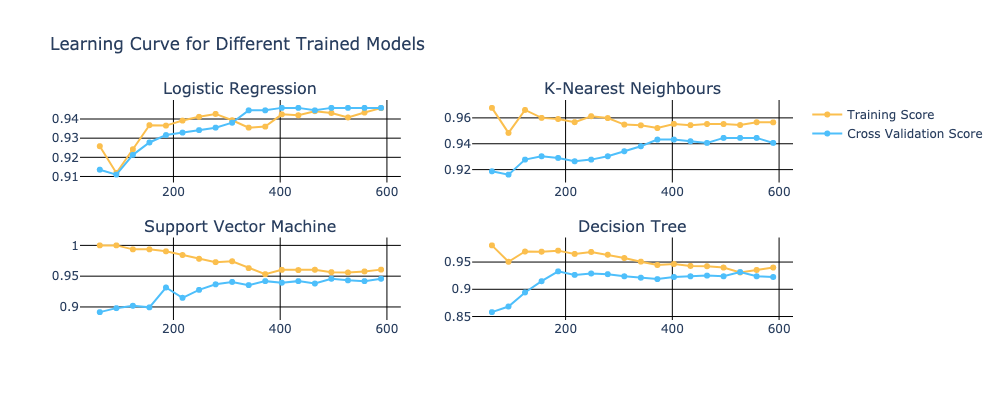

In [328]:
n_jobs = 1
cv = 5
train_sizes = np.arange(0.1, 1.0, 0.05)

learning_curve_plot = make_subplots(rows=2, cols=2,
                                    subplot_titles=list(models_dict.keys()))
counter = 0
# need coordinate vector for where to plot in plotly subplot. 
plot_coords_vec = [[1,1], [1,2], [2,1], [2,2]]


#Note: learning curve will use by default a 5 CV split - output is a length 3 tuple:
# First element are the training sizes. Second is the training scores, 3rd is the cv scores. 
# These matrics have shape: Num_train_sizes x CV_Folds
for model_type, (model, hyper_params) in models_dict.items():
    data_size, train_score, test_score = learning_curve(model, X_train, y_train, 
                                                        n_jobs=n_jobs, random_state=42, 
                                                        train_sizes=train_sizes, cv=cv)

    train_mean = train_score.mean(axis=1)
    test_mean = test_score.mean(axis=1)

    # Plotting:
    showlegend = True
    if counter > 0:
        showlegend = False
    plot_coords = plot_coords_vec[counter]
    row = plot_coords[0]
    col = plot_coords[1]
    counter += 1

    learning_curve_plot.add_trace(go.Scatter(x=data_size, y=train_mean, line_color="#FBBF4E", showlegend=showlegend, name="Training Score", fill=None), row=row, col=col)
    learning_curve_plot.add_trace(go.Scatter(x=data_size, y=test_mean, line_color="#4EBFFB", showlegend=showlegend, name="Cross Validation Score", fill=None), row=row, col=col)

learning_curve_plot.update_layout(title="Learning Curve for Different Trained Models")
learning_curve_plot.update_layout(plot_bgcolor='rgba(0,0,0,0)', width=1000, height=400)
learning_curve_plot.update_xaxes(showgrid=True, gridwidth=1, gridcolor='Black')
learning_curve_plot.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Black')
learning_curve_plot.show()

All models seem to perform similarly but the standouts are Logistic regression and SVM. Given the simplicity of LogReg (more expainable) and the fact that convergence is almost identical to the SVM curve I'd lean towards the LogReg approach. However let's look at some confusion matrices between the models.

If comparing precision vs recall: in this case we'd want a higher recall. This means that fraudulent transactions are indeed flagged. 

Ploting some confusion matrices for each model using our test set:

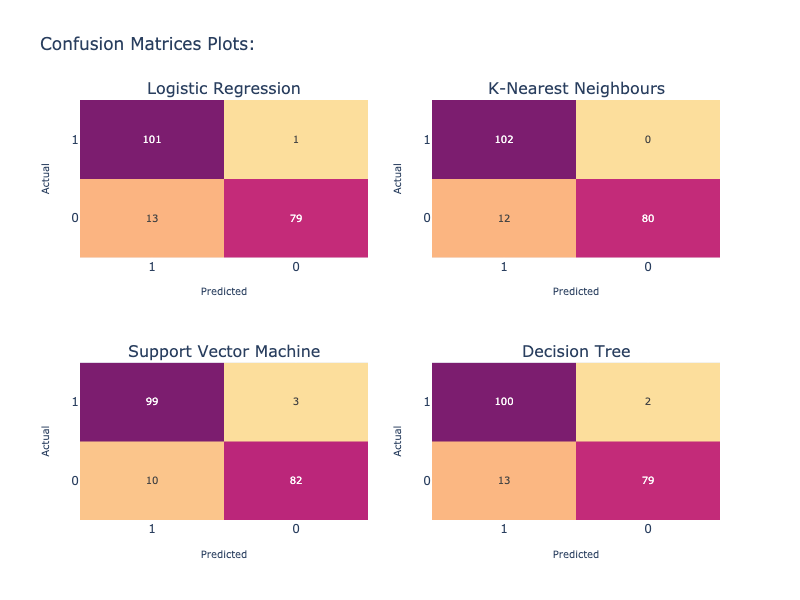

In [329]:
confusion_matrix_plot = make_subplots(rows=2, cols=2,
                                    subplot_titles=list(models_dict.keys()))
counter = 0
# need coordinate vector for where to plot in plotly subplot. 
plot_coords_vec = [[1,1], [1,2], [2,1], [2,2]]

for model_type, (model, hyper_params) in models_dict.items():

    # plotting variables
    plot_coords = plot_coords_vec[counter]
    row = plot_coords[0]
    col = plot_coords[1]
    counter += 1
    
    # plotting confusion matrix:
    y_test_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_mat_str = np.flipud(conf_mat.astype(str))
    confusion_matrix_plot.add_trace(go.Heatmap(z=np.flipud(conf_mat), 
                                               x=["1","0"], y=["0","1"], 
                                               colorscale='Sunsetdark',
                                               text=conf_mat_str,
                                               texttemplate="%{text}",
                                               textfont={"size":10}), row=row, col=col)
    confusion_matrix_plot.update_traces(showscale=False)
    confusion_matrix_plot.update_xaxes(title_text="Predicted", title_font=dict(size=10), row=row, col=col)
    confusion_matrix_plot.update_yaxes(title_text="Actual", title_font=dict(size=10), row=row, col=col)
    

confusion_matrix_plot.update_layout(title="Confusion Matrices Plots:", height=600, width=800)
confusion_matrix_plot.update_coloraxes(showscale=False)
confusion_matrix_plot.show()

Based on these confusion matrices and learning curves - the decision of which model should be used is still unclear. Let's get a classification report of only these models to get a final idea:

In [330]:
for model_type, (model, optim_param) in models_dict.items():

    if model_type in ["Logistic Regression", "Support Vector Machine", "Decision Tree"]:
        # Adding Classification Report Printing:
        print(f"For {model_type}:")
        print("----" * 7)
        print(classification_report(y_test, y_test_pred))
    

For Logistic Regression:
----------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       102
           1       0.98      0.86      0.91        92

    accuracy                           0.92       194
   macro avg       0.93      0.92      0.92       194
weighted avg       0.93      0.92      0.92       194

For Support Vector Machine:
----------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       102
           1       0.98      0.86      0.91        92

    accuracy                           0.92       194
   macro avg       0.93      0.92      0.92       194
weighted avg       0.93      0.92      0.92       194

For Decision Tree:
----------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       102
           1       0.98      0.86      0.91        92

    accuracy           

Conclusion: 

Both models perform almost identically on our randomly undersampled datasets. For production I would suggest a LogReg/Decision tree approach - this is because I feel in a banking sense our models need to be explainable due to regulations - hence the simpler the model the better. I'm sure there's more that can be done to improve these models:

- Error Analysis to see where if any similarities between misclassified datapoints. 
- SMOTE: instead of undersampling lets generate synthetic datapoints. I am quite against this in tabular data but nevertheless could be worth exploring. 
- Deep Learning Frameworks: could use a neural net to model the problem. 

Let's end with moving LogReg and Decision tree models in our model registry on MlFlow so that in a real working environment ML Engineers know which models are going into production etc.

Add logistic regression model to model registry.

In [272]:
run_id = mlflow.search_runs(filter_string="run_name='Logistic Regression'")["run_id"].iloc[0]
model_uri = "runs/" + run_id + "/Logistic Regression - Model"
mlflow.register_model(model_uri=model_uri, name="Fraud Detection Model")

Registered model 'Fraud Detection Model' already exists. Creating a new version of this model...
2023/06/15 22:26:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Fraud Detection Model, version 3
Created version '3' of model 'Fraud Detection Model'.


<ModelVersion: aliases=[], creation_timestamp=1686864403125, current_stage='None', description=None, last_updated_timestamp=1686864403125, name='Fraud Detection Model', run_id=None, run_link=None, source='runs/99b9fe79a002497bbd365a643062dfdf/Logistic Regression - Model', status='READY', status_message=None, tags={}, user_id=None, version=3>

Add decision tree model to Model Registry:

In [273]:
run_id = mlflow.search_runs(filter_string="run_name='Decision Tree'")["run_id"].iloc[0]
model_uri = "runs/" + run_id + "/Decision Tree - Model"
mlflow.register_model(model_uri=model_uri, name="Fraud Detection Model")


Registered model 'Fraud Detection Model' already exists. Creating a new version of this model...
2023/06/15 22:26:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Fraud Detection Model, version 4
Created version '4' of model 'Fraud Detection Model'.


<ModelVersion: aliases=[], creation_timestamp=1686864403301, current_stage='None', description=None, last_updated_timestamp=1686864403301, name='Fraud Detection Model', run_id=None, run_link=None, source='runs/fd5cbd6194884ef085124431dfaf6d65/Decision Tree - Model', status='READY', status_message=None, tags={}, user_id=None, version=4>

For fun let's assume we're replacing the decision tree model with the LogRed model. This means setting decision tree model to production and logReg model to "staging".

In [274]:
# Create MlFlow client to interact with model registry:
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [275]:
model_version = 2
model_name = "Fraud Detection Model"
new_stage = "Production"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: aliases=[], creation_timestamp=1686700722684, current_stage='Production', description='Decision Tree Model ', last_updated_timestamp=1686864403560, name='Fraud Detection Model', run_id=None, run_link=None, source='runs/101fd17a35764719952e9dcb38e0b830/Decision Tree - Model', status='READY', status_message=None, tags={}, user_id=None, version=2>

Setting version of LogReg model to staging:

In [276]:
model_version = 1
model_name = "Fraud Detection Model"
new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: aliases=[], creation_timestamp=1686700559321, current_stage='Staging', description='Logistic Regression Model', last_updated_timestamp=1686864403667, name='Fraud Detection Model', run_id=None, run_link=None, source='runs/ed8a728655ef491baa5fdb8a3e72b7a1/Logistic Regression - Model', status='READY', status_message=None, tags={}, user_id=None, version=1>

![alt text](./extras/MLFlow_Model_Registry.png "Model Registry")

That's it for this notebook - happy coding! :) 